In [49]:
import numpy as np
from scipy.optimize import dual_annealing
import pulp
import pandas as pd
import os
import random
from wmape import WMAPE
from order_generator import OrderGenerator
from order_merger import OrderMerger
import math
import matplotlib.pyplot as plt

In [50]:
random.seed(42)

In [51]:
allocation_dir = 'allocations'
merged_dir = 'merged'

In [52]:
def objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day):
    # Apply the current allocation to the orders dataframe
    orders_df['site'] = current_allocation

    # Aggregate the orders for the initial and target lead days
    aggregated_initial_df = OrderMerger.aggregate_items(orders_df, initial_day)
    aggregated_target_df = OrderMerger.aggregate_items(target_orders_df, target_day)

    # Merge the aggregated dataframes
    merged_df = OrderMerger.merge_allocation(aggregated_initial_df, aggregated_target_df, initial_day, target_day)

    # Calculate WMAPE
    _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{target_day}', f'lead_{initial_day}')
    return wmape_site

In [53]:
# Generate Neighbor Function
def generate_neighbor(current_allocation, orders_df, eligibility_dict):
    new_allocation = current_allocation.copy()
    max_attempts = 100  # Limit the number of attempts to find a valid swap

    unique_order_ids = orders_df['order_id'].unique()

    for _ in range(max_attempts):
        order_indices = random.sample(range(len(unique_order_ids)), 2)

        order_id1 = unique_order_ids[order_indices[0]]
        order_id2 = unique_order_ids[order_indices[1]]

        items1 = orders_df[orders_df['order_id'] == order_id1]['item_id'].tolist()
        items2 = orders_df[orders_df['order_id'] == order_id2]['item_id'].tolist()

        site1 = new_allocation[orders_df[orders_df['order_id'] == order_id1].index[0]]
        site2 = new_allocation[orders_df[orders_df['order_id'] == order_id2].index[0]]

        if all(item in eligibility_dict[site2] for item in items1) and all(item in eligibility_dict[site1] for item in items2):
            # Perform the swap if both are eligible
            new_allocation[orders_df[orders_df['order_id'] == order_id1].index] = site2
            new_allocation[orders_df[orders_df['order_id'] == order_id2].index] = site1
            break

    return new_allocation

In [54]:
# k-opt Algorithm
def k_opt(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, k, max_iter):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    step = 0

    while step < max_iter:
        neighbors = []
        for _ in range(k):
            new_allocation = generate_neighbor(current_allocation, orders_df, eligibility_dict)
            new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)
            neighbors.append((new_allocation, new_energy))

        # Select the best neighbor
        best_neighbor_allocation, best_neighbor_energy = min(neighbors, key=lambda x: x[1])

        if best_neighbor_energy < current_energy:
            current_allocation = best_neighbor_allocation
            current_energy = best_neighbor_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        step += 1

        # Debug statement to trace the progress
        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}')

    # Debug statement for final values
    print(f'Final Step: {step}, Final Best Energy: {best_energy}')
    return best_allocation, best_energy


# Perform k-opt Between Consecutive Days
def perform_k_opt(lead_days, k, max_iter, eligibility_dict):
    # Load the initial allocation dataframe for the first lead day
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    
    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{lead_days[0]}.csv', index=False)
    
    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i-1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')
        
        best_allocation, best_energy = k_opt(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, k, max_iter)
        
        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation
        
        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{current_day}.csv', index=False)
        
        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()

In [55]:
# Aggregate, Merge DataFrames and Calculate WMAPE
def calculate_wmape_for_all_days(lead_days, k):
    wmape_site_values = []
    wmape_global_values = []

    final_day = lead_days[-1]
    final_day_df = pd.read_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{final_day}.csv')
    aggregated_final_day = OrderMerger.aggregate_items(final_day_df, final_day)
    
    for day in lead_days[:-1]:
        current_df = pd.read_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{day}.csv')
        aggregated_current_day = OrderMerger.aggregate_items(current_df, day)
        
        merged_df = OrderMerger.merge_allocation(aggregated_current_day, aggregated_final_day, day, final_day)
        
        site_df, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{day}', f'lead_{final_day}')
        global_df, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{day}', f'lead_{final_day}')
        
        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)
        
        # Save the merged dataframe
        merged_df.to_csv(f'{k}opt_merged/{k}_merged_allocation_lead_day_{day}_to_{final_day}.csv', index=False)
    
    # Add 0 for lead day 0
    wmape_site_values.append(0)
    wmape_global_values.append(0)
    
    return wmape_site_values, wmape_global_values

In [56]:

def plot_wmape(lead_days, wmape_site_values, wmape_global_values):
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days, wmape_site_values, linestyle='-', color='b', label='WMAPE Site')
    ax.plot(lead_days, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')

    # Add labels and title
    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Different Lead Days')
    ax.set_xticks(lead_days)
    ax.legend()

    # Invert x-axis to have 0 at the end
    ax.invert_xaxis()

    plt.show()

In [ ]:

lead_days = list(range(18, -1, -1))  # Define the lead days from 18 to 0
k = 2  # Number of neighbors to generate in each iteration
max_iter = 1000

eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')
# Perform k-opt for consecutive lead days
perform_k_opt(lead_days, k, max_iter, eligibility_dict)

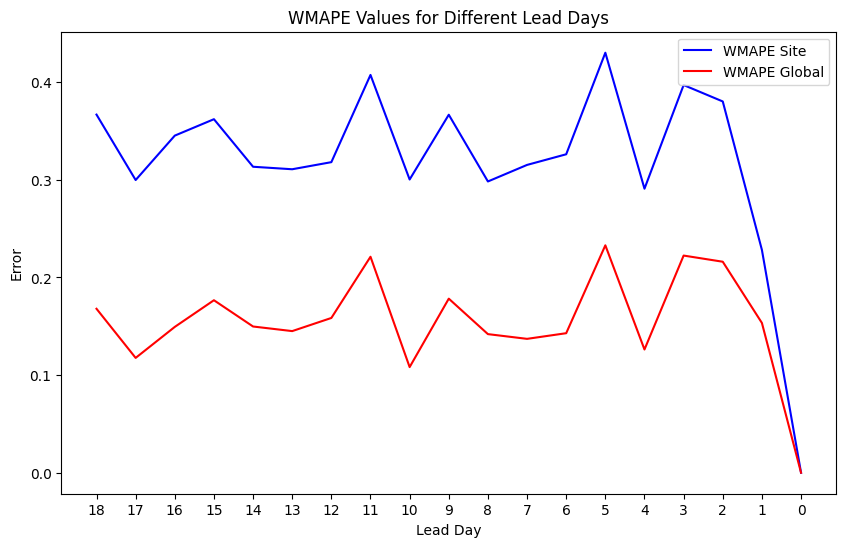

In [25]:
# Calculate WMAPE for all days
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days, 2)
# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

In [18]:
eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')
pairs = [(18, 17), (17, 16), (16, 15), (15, 14), (14, 13), (13, 12), (12, 11), (11, 10), (10, 9), (9, 8), (8, 7), (7, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 1), (1, 0)]
lead_days = list(range(18, -1, -1))

In [28]:
def two_opt(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, max_iter=1000):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    step = 0
    while step < max_iter:
        # Select random order A
        a_index = random.choice(range(len(current_allocation)))
        a_order_id = orders_df.iloc[a_index]['order_id']

        # Attempt to swap with random orders until a valid swap is found
        valid_swap = False
        while not valid_swap and step < max_iter:
            b_index = random.choice(range(len(current_allocation)))
            if b_index != a_index:
                b_order_id = orders_df.iloc[b_index]['order_id']
                
                # Perform the swap
                new_allocation = current_allocation.copy()
                new_allocation[a_index], new_allocation[b_index] = new_allocation[b_index], new_allocation[a_index]

                # Check eligibility criteria
                a_items = orders_df[orders_df['order_id'] == a_order_id]['item_id'].values
                b_items = orders_df[orders_df['order_id'] == b_order_id]['item_id'].values
                a_site = new_allocation[a_index]
                b_site = new_allocation[b_index]

                if all(item in eligibility_dict[a_site] for item in a_items) and all(item in eligibility_dict[b_site] for item in b_items):
                    valid_swap = True
                    new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)
                    if new_energy < best_energy:
                        best_allocation = new_allocation
                        best_energy = new_energy
                        current_allocation = best_allocation
                        current_energy = best_energy
                    else:
                        current_allocation = new_allocation
            
            step += 1

    return best_allocation, best_energy

In [29]:
def three_opt(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, max_iter=1000):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    step = 0
    n = len(current_allocation)

    while step < max_iter:
        # Select three random indices
        i, j, k = np.random.choice(n, 3, replace=False)
        new_allocation_1 = current_allocation.copy()
        new_allocation_2 = current_allocation.copy()
        new_allocation_3 = current_allocation.copy()
        
        # Perform the swaps
        new_allocation_1[i], new_allocation_1[j] = new_allocation_1[j], new_allocation_1[i]  # Swap A with B, leave C
        new_allocation_2[j], new_allocation_2[k] = new_allocation_2[k], new_allocation_2[j]  # Swap B with C, leave A
        new_allocation_3[i], new_allocation_3[k] = new_allocation_3[k], new_allocation_3[i]  # Swap A with C, leave B

        # Check eligibility criteria
        def is_valid(allocation, indices):
            for idx in indices:
                order_id = orders_df.iloc[idx]['order_id']
                item_ids = orders_df[orders_df['order_id'] == order_id]['item_id'].values
                site = allocation[idx]
                if not all(item in eligibility_dict[site] for item in item_ids):
                    return False
            return True
        
        valid_swap_1 = is_valid(new_allocation_1, [i, j])
        valid_swap_2 = is_valid(new_allocation_2, [j, k])
        valid_swap_3 = is_valid(new_allocation_3, [i, k])

        best_local_allocation = current_allocation
        best_local_energy = current_energy

        if valid_swap_1:
            new_energy_1 = objective_function(new_allocation_1, orders_df, target_orders_df, initial_day, target_day)
            if new_energy_1 < best_local_energy:
                best_local_allocation = new_allocation_1
                best_local_energy = new_energy_1

        if valid_swap_2:
            new_energy_2 = objective_function(new_allocation_2, orders_df, target_orders_df, initial_day, target_day)
            if new_energy_2 < best_local_energy:
                best_local_allocation = new_allocation_2
                best_local_energy = new_energy_2

        if valid_swap_3:
            new_energy_3 = objective_function(new_allocation_3, orders_df, target_orders_df, initial_day, target_day)
            if new_energy_3 < best_local_energy:
                best_local_allocation = new_allocation_3
                best_local_energy = new_energy_3

        # Update the best allocation and energy if an improvement is found
        if best_local_energy < best_energy:
            best_allocation = best_local_allocation
            best_energy = best_local_energy
            current_allocation = best_allocation
            current_energy = best_energy
        else:
            current_allocation = best_local_allocation
            current_energy = best_local_energy

        step += 1

    return best_allocation, best_energy

In [30]:
def perform_2_or_3_opt(lead_days, k, max_iter, eligibility_dict):
    # Load the initial allocation dataframe for the first lead day
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    
    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{lead_days[0]}.csv', index=False)
    
    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i-1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')

        if k == 2:
            best_allocation, best_energy = two_opt(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, max_iter)
        elif k== 3:
            best_allocation, best_energy = three_opt(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, max_iter)
        
        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation
        
        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{k}opt_allocations/{k}_opt_allocation_lead_day_{current_day}.csv', index=False)
        
        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()

In [58]:
def calculate_and_plot_wmape(pairs, k):
    wmape_site_values = []
    wmape_global_values = []
    wmape_site_kopt_values = []
    wmape_global_kopt_values = []

    kopt_allocation_dir = f'{k}opt_allocations'  # Path to the directory containing the simulated annealing allocation files
    kopt_merged_allocation_dir = f'{k}opt_merged_consec'  # Path to the directory to save the merged allocation files

    for current_day, previous_day in pairs:


        merged_df = pd.read_csv(f'merged_consec/merged_allocation_lead_day_{current_day}_to_{previous_day}.csv')
        _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{current_day}', f'lead_{previous_day}')
        _, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{current_day}', f'lead_{previous_day}')

        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)

        # With simulated annealing
        current_df_kopt = pd.read_csv(f'{kopt_allocation_dir}/{k}_opt_allocation_lead_day_{current_day}.csv')
        previous_df_kopt = pd.read_csv(f'{kopt_allocation_dir}/{k}_opt_allocation_lead_day_{previous_day}.csv')

        aggregated_current_day_kopt = OrderMerger.aggregate_items(current_df_kopt, current_day)
        aggregated_previous_day_kopt = OrderMerger.aggregate_items(previous_df_kopt, previous_day)

        merged_df_kopt = OrderMerger.merge_allocation(aggregated_current_day_kopt, aggregated_previous_day_kopt, current_day, previous_day)

        _, wmape_site_kopt = WMAPE.calculate_wmape_site(merged_df_kopt, f'lead_{current_day}', f'lead_{previous_day}')
        _, wmape_global_kopt = WMAPE.calculate_wmape_global(merged_df_kopt, f'lead_{current_day}', f'lead_{previous_day}')

        wmape_site_kopt_values.append(wmape_site_kopt)
        wmape_global_kopt_values.append(wmape_global_kopt)

        # Save the merged dataframes with simulated annealing
        merged_df_kopt.to_csv(f'{kopt_merged_allocation_dir}/merged_allocation_{k}_opt_lead_day_{current_day}_to_{previous_day}.csv', index=False)

    lead_days_consecutive = [previous_day for _, previous_day in pairs]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days_consecutive, wmape_site_values, linestyle='-', color='b', label='WMAPE Site Without Genetic Algorithm')
    ax.plot(lead_days_consecutive, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')
    ax.plot(lead_days_consecutive, wmape_site_kopt_values, linestyle='--', color='b', label='WMAPE Site With Genetic Algorithm')

    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Consecutive Lead Days')
    ax.set_xticks(lead_days_consecutive)
    ax.legend()

    ax.invert_xaxis()

    plt.show()

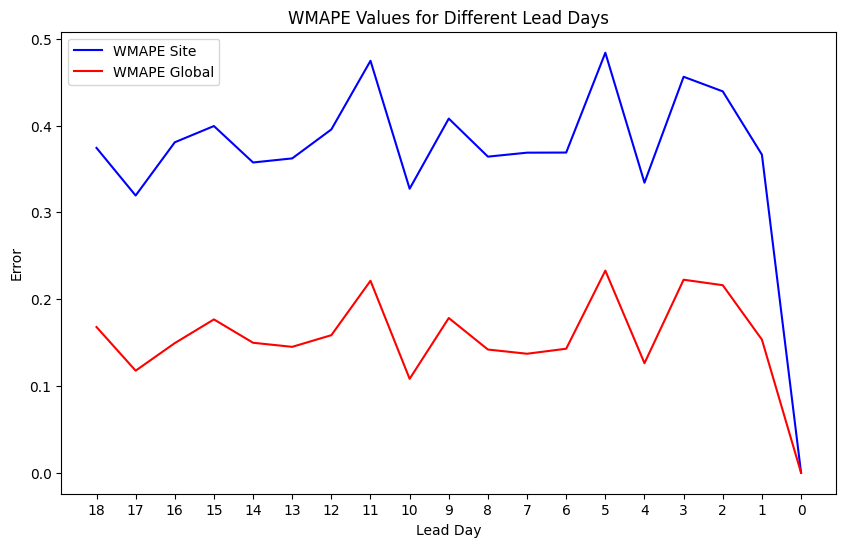

In [35]:
perform_2_or_3_opt(lead_days, 2, max_iter=5000, eligibility_dict=eligibility_dict)
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days, 2)
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

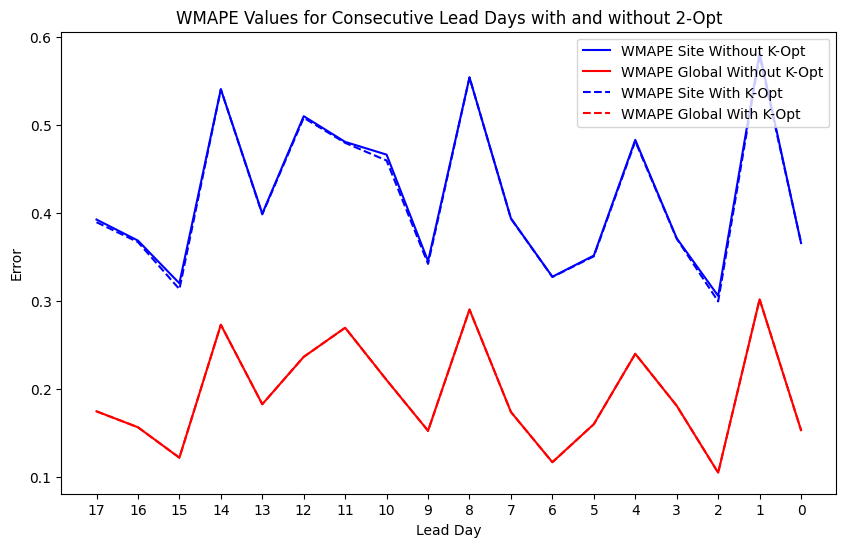

In [41]:
calculate_and_plot_wmape(pairs, k=2)

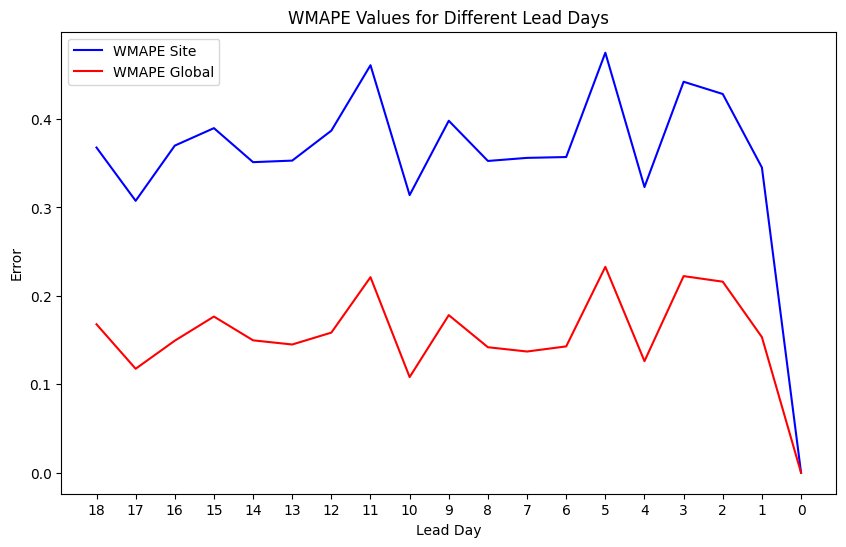

In [63]:
perform_2_or_3_opt(lead_days, 3, max_iter=500, eligibility_dict=eligibility_dict)
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days, 3)
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

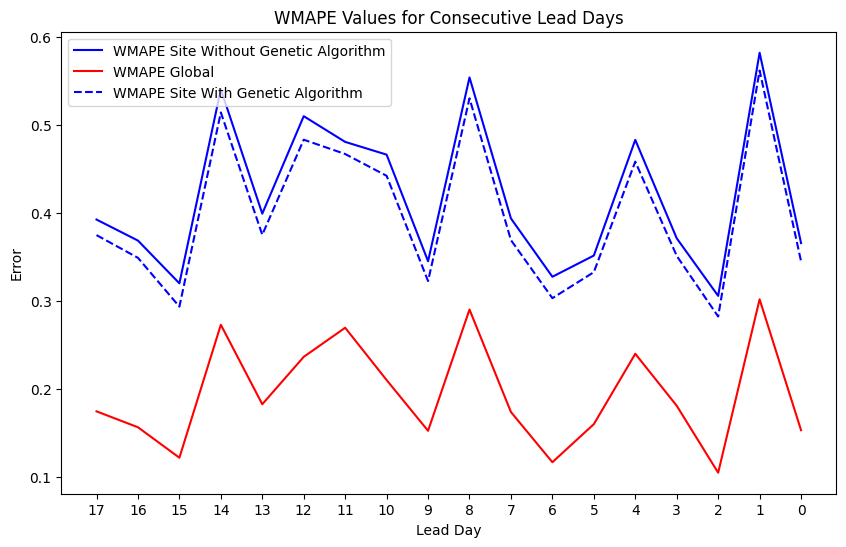

In [64]:
calculate_and_plot_wmape(pairs, k=3)

In [65]:
def calculate_wmape_for_merged_files(merged_dir, pairs, k):
    wmape_site_values = []
    wmape_global_values = []

    for current_day, previous_day in pairs:
        merged_df = pd.read_csv(f'{merged_dir}/merged_allocation_{k}_opt_lead_day_{current_day}_to_{previous_day}.csv')

        _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{current_day}', f'lead_{previous_day}')
        _, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{current_day}', f'lead_{previous_day}')

        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)

    return wmape_site_values, wmape_global_values

pairs = [(18, 17), (17, 16), (16, 15), (15, 14), (14, 13), (13, 12), (12, 11), (11, 10), (10, 9), (9, 8), (8, 7), (7, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 1), (1, 0)]

merged_dir_2opt = '2opt_merged_consec'  # Path to the directory containing the 2-opt merged files
merged_dir_3opt = '3opt_merged_consec'  # Path to the directory containing the 3-opt merged files

wmape_site_2opt, wmape_global_2opt = calculate_wmape_for_merged_files(merged_dir_2opt, pairs, 2)
wmape_site_3opt, wmape_global_3opt = calculate_wmape_for_merged_files(merged_dir_3opt, pairs, 3)

lead_days_consecutive = [current_day for current_day, _ in pairs]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(lead_days_consecutive, wmape_site_2opt, linestyle='-', color='b', label='WMAPE Site 2-opt')
ax.plot(lead_days_consecutive, wmape_global_2opt, linestyle='-', color='r', label='WMAPE Global 2-opt')
ax.plot(lead_days_consecutive, wmape_site_3opt, linestyle='--', color='b', label='WMAPE Site 3-opt')
ax.plot(lead_days_consecutive, wmape_global_3opt, linestyle='--', color='r', label='WMAPE Global 3-opt')

ax.set_xlabel('Lead Day')
ax.set_ylabel('Error')
ax.set_title('WMAPE Values for Consecutive Lead Days with 2-opt and 3-opt')
ax.set_xticks(lead_days_consecutive)
ax.legend()

ax.invert_xaxis()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '3opt_merged_consec/merged_allocation_3_opt_lead_day_18_to_17.csv'